## 1. Attention machanism
Given the sentence: **"I love foundation models"**

You are provided with token embeddings as follows (embedding dimension $d_k = 3$):

| Token      | Embedding        |
|------------|------------------|
| I          | [1, 0, 1]        |
| love       | [0, 1, 1]        |
| foundation | [1, 1, 0]        |
| models     | [0, 1, 0]        |

Assume weight matrices for Query, Key, and Value are identity matrices:
- $W^Q = W^K = W^V = I$

Thus:
- $Q = K = V = $ embedding matrix

### 1.1 Computing attention vectors
#### Step 1: Build the Q, K, V matrices
- Stack the token embeddings into a matrix of shape (4, 3)
- Treat this as Query (Q), Key (K), and Value (V)

#### Step 2: Compute attention scores
- Use the scaled dot-product attention formula:
  $$
  \text{scores} = \frac{QK^T}{\sqrt{d_k}}
  $$
  where $d_k = 3$

#### Step 3: Apply softmax for each row
- This will produce attention weights for each token with respect to the others
  $$
  \text{weights} = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)
  $$

#### Step 4: Compute context vectors
- Multiply attention weights with V:
  $$
  \text{Attention(Q, K, V)} = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
  $$
- Each row in the result corresponds to the attention vector for one token

### 1.2 Implementation in Python

In [1]:
import numpy as np
from scipy.special import softmax

# Step 1: Token embeddings
embeddings = np.array([
    [1, 0, 1],  # I
    [0, 1, 1],  # love
    [1, 1, 0],  # foundation
    [0, 1, 0]   # models
])

Q = K = V = embeddings

# Step 2: Attention scores
dk = 3
scores = np.dot(Q, K.T) / np.sqrt(dk)

# Step 3: Softmax over each row
weights = softmax(scores, axis=1)

# Step 4: Compute attention vectors
attention = np.dot(weights, V)

# Print results
print("Attention scores:\n", scores)
print("\nAttention weights:\n", weights)
print("\nAttention vectors:\n", attention)

Attention scores:
 [[1.15470054 0.57735027 0.57735027 0.        ]
 [0.57735027 1.15470054 0.57735027 0.57735027]
 [0.57735027 0.57735027 1.15470054 0.57735027]
 [0.         0.57735027 0.57735027 0.57735027]]

Attention weights:
 [[0.41018578 0.2302717  0.2302717  0.12927083]
 [0.20914761 0.37255718 0.20914761 0.20914761]
 [0.20914761 0.20914761 0.37255718 0.20914761]
 [0.15763083 0.28078972 0.28078972 0.28078972]]

Attention vectors:
 [[0.64045748 0.58981422 0.64045748]
 [0.41829521 0.79085239 0.58170479]
 [0.58170479 0.79085239 0.41829521]
 [0.43842056 0.84236917 0.43842056]]


## 2. Transformer model
#### Using a Transformer Model for Classification

The tutorial is based on: https://fall-2023-python-programming-for-data-science.readthedocs.io/en/latest/Lectures/Theme_3-Model_Engineering/Lecture_20-Transformer_Networks/Lecture_20-Transformer_Networks.html#20.1-Introduction-to-Transformers

The `Encoder` block is implemented as a custom layer which is a subclass of the `Layer` class in Keras. The `__init__()` constructor method lists the definitions of the layers in the `Encoder`, and the method `call()` provides the forward pass with the flow of information through the layers.

- `Multi-head attention` layer is implemented in Keras, and it can be directly imported. The arguments in the layer are: `num_heads` is the number of attention heads, and `key_dim` is the dimension of the embeddings of the input tokens.

- `Dropout` and `Normalization` layers are also directly imported, with arguments rate for the dropout rate, and epsilon is a small float added to the standard deviation to avoid division by 0.

- Feed forward network includes 2 dense layers, with the number of neurons set to `ff_dim` and `embed_dim`, respectively.

The `call()` method specifies the forward pass of the network, and takes two parameters: `inputs` (the input embeddings to the network) and `training` (an argument which can be `True` or `False`). For the dropout layers, during the model training this argument is set to `True` and dropout is applied, while during inference the argument is set to `False` and dropout is not applied.

Each step in the `call()` method performs the data processing for one layer. Note that the `multi_head_attention` layer has as arguments the inputs twice, which is once for the key and once for the value in the self-attention. Also note the residual connections that are implemented in the layer normalization, e.g., the inputs are added to the output of the multi-head attention.

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Dense, Embedding, Layer
from keras import Sequential, Model

In [3]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.multi_head_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.feed_forward_net = Sequential([Dense(ff_dim, activation="relu"), Dense(embed_dim),])
        self.layer_normalization1 = LayerNormalization(epsilon=1e-6)
        self.layer_normalization2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        multi_head_att_output = self.multi_head_attention(inputs, inputs)
        multi_head_att_dropout = self.dropout1(multi_head_att_output, training=training)
        add_norm_output_1 = self.layer_normalization1(inputs + multi_head_att_dropout)
        feed_forward_output = self.feed_forward_net(add_norm_output_1)
        feed_forward_dropout = self.dropout2(feed_forward_output, training=training)
        add_norm_output_2 = self.layer_normalization2(add_norm_output_1 + feed_forward_dropout)
        return add_norm_output_2

 In this case, we will use the approach for obtaining positional encodings based on sine and cosine functions.

In [4]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_embeddings = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.maxlen = maxlen
        self.embed_dim = embed_dim

    def get_sinusoidal_encoding(self, position, d_model):
        angle_rates = 1 / np.power(10000, (2 * (np.arange(d_model)[np.newaxis, :] // 2)) / np.float32(d_model))
        angle_rads = position[:, np.newaxis] * angle_rates

        # apply sin to even indices; cos to odd indices
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
        return tf.convert_to_tensor(angle_rads, dtype=tf.float32)

    def call(self, inputs):
        input_embeddings = self.token_embeddings(inputs)  # (batch_size, seq_len, embed_dim)
        seq_len = tf.shape(inputs)[1]

        # Precompute positional encodings
        positions = tf.range(start=0, limit=seq_len, delta=1)
        positional_encodings = self.get_sinusoidal_encoding(
            np.arange(self.maxlen), self.embed_dim
        )  # (maxlen, embed_dim)

        # Slice only the needed positions
        positional_encodings = positional_encodings[:seq_len]
        positional_encodings = tf.expand_dims(positional_encodings, 0)  # (1, seq_len, embed_dim)

        return input_embeddings + positional_encodings

We will now employ the layers that we defined above, to create a `Transformer` model for text classification.

It is a simple model that consists of the following parts:

- `Encoder`, which includes an `Input` layer that defines the maximum length of input sequences, `TokenAndPositionEmbedding` layer, and the `TransformerEncoder` layer.

- `Classifier`, which consists of a `GlobalAveragePooling1D` layer, and two `Dropout` and `Dense` layers. Global Average Pooling calculates the average value for each word, and it passes those values to the dense layers to classify the text sequences.

In [5]:
from keras.layers import Input, GlobalAveragePooling1D

maxlen = 200  # Maximum length of input sequences is 200 words
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Dense layer size in the feed forward network inside transformer
vocab_size = 20000  # The size of the vocabulary is 20k words

# encoder
inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)(inputs)
x = TransformerEncoder(embed_dim, num_heads, ff_dim)(embedding_layer,training=True)

# classifier
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(1, activation="sigmoid")(x)

model = Model(inputs=inputs, outputs=outputs)

In [6]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 200, 32)        │       640,000 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder             │ (None, 200, 32)        │        10,656 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 651,337 (2.48 MB)

 Trainable params: 651,337 (2.48 MB)

 Non-trainable params: 0 (0.00 B)

Let’s apply the model for sentiment analysis of the movie reviews in the IMDB database. The data is loaded from the Keras datasets, and it contains 25,000 training sequences and 25,000 validation sequences.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Parameters
vocab_size = 20000
maxlen = 200

# Load IMDB dataset (keras default loads "train" set only)
(x, y), _ = keras.datasets.imdb.load_data(num_words=vocab_size)
# Pad all sequences to the same length
x = pad_sequences(x, maxlen=maxlen)

In [8]:
#Show some sample records:
# Get word index (mapping from word -> index), and invert it
word_index = keras.datasets.imdb.get_word_index()
index_to_word = {index + 3: word for word, index in word_index.items()}
index_to_word[0] = "<PAD>"
index_to_word[1] = "<START>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

# Decode function: list of ints -> text
def decode_review(encoded_review):
    return ' '.join(index_to_word.get(i, '?') for i in encoded_review)

# Show 2 sample records
for i in range(2):
    print(f"Sample {i+1}:")
    print("Text  :", decode_review(x[i]))
    print("Label :", y[i])  # 0 = negative, 1 = positive
    print("-" * 80)

Sample 1:
Text  : and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you think the whole story was so lovely because it was true and was s

#### Task:
Train the transformer model on the IMDB dataset, splitting it into 80% for training (with 10% for validation) and 20% for testing. Evaluate the model's performance using accuracy and plot the training and validation accuracy over the epochs.

Epoch 1/10
Train Loss: 0.6235, Acc: 0.6459
Val Loss: 0.5253, Acc: 0.7352
--------------------------------------------------
Epoch 2/10
Train Loss: 0.4558, Acc: 0.7904
Val Loss: 0.4298, Acc: 0.8020
--------------------------------------------------
Epoch 3/10
Train Loss: 0.3652, Acc: 0.8433
Val Loss: 0.3831, Acc: 0.8292
--------------------------------------------------
Epoch 4/10
Train Loss: 0.3066, Acc: 0.8744
Val Loss: 0.3844, Acc: 0.8284
--------------------------------------------------
Epoch 5/10
Train Loss: 0.2623, Acc: 0.8952
Val Loss: 0.3608, Acc: 0.8446
--------------------------------------------------
Epoch 6/10
Train Loss: 0.2282, Acc: 0.9111
Val Loss: 0.3439, Acc: 0.8560
--------------------------------------------------
Epoch 7/10
Train Loss: 0.2001, Acc: 0.9231
Val Loss: 0.3423, Acc: 0.8596
--------------------------------------------------
Epoch 8/10
Train Loss: 0.1698, Acc: 0.9374
Val Loss: 0.3526, Acc: 0.8604
--------------------------------------------------
Epoch 9/

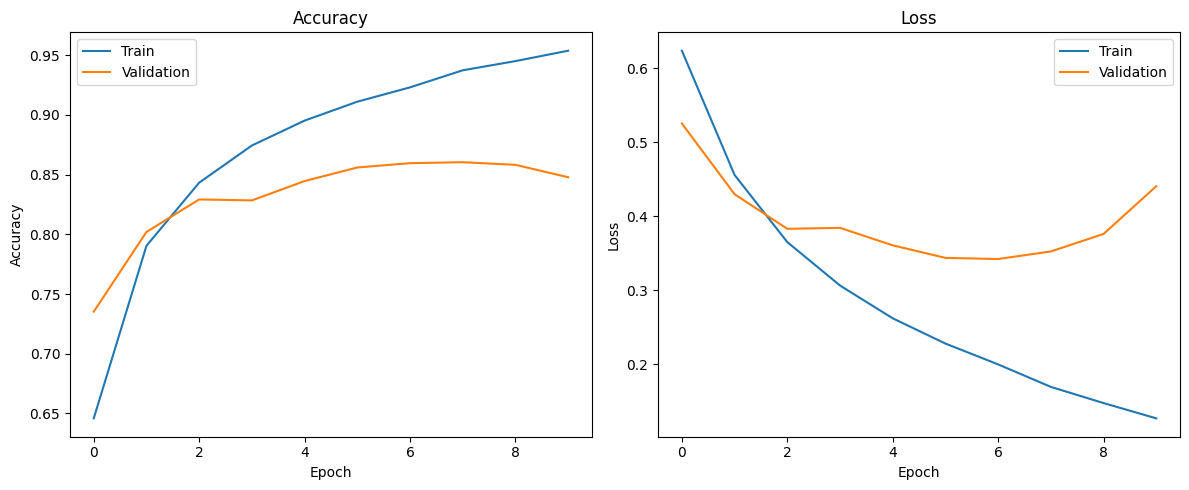

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

# Parameters
vocab_size = 20000
maxlen = 200
batch_size = 32
epochs = 10

# 1. Load and preprocess the data
(x_train_val, y_train_val), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
x_train_val = pad_sequences(x_train_val, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

# 2. Split into train (80%), validation (10%), and test (10%)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val,
    test_size=0.2,  # 20% of original = 10% of total
    random_state=42
)

# 3. Convert to PyTorch tensors
train_data = TensorDataset(torch.LongTensor(x_train), torch.LongTensor(y_train))
val_data = TensorDataset(torch.LongTensor(x_val), torch.LongTensor(y_val))
test_data = TensorDataset(torch.LongTensor(x_test), torch.LongTensor(y_test))

# 4. Create data loaders
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

# 5. Define model
embed_dim = 32
num_heads = 2
ff_dim = 32

class TransformerModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.transformer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim
        )
        self.fc = nn.Linear(embed_dim, 2)  # 2 classes for binary classification

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.fc(x)
        return x

model = TransformerModel()

# 6. Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 7. Training loop
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    print("-" * 50)

# 8. Test evaluation
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")

# 9. Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()